# Лекция 4. Сверточные нейронные сети

###Оптимизаторы и валидационная выборка

Когда необходимо решить задачу с помощью НС, то каждый раз, приходится определяться:

- со структурой НС;

- способами оптимизации алгоритма градиентного спуска;

- критерием качества;

- способом формирования выборки валидации из обучающего множества.

И некоторыми другими, более простыми и очевидными параметрами.

До сих пор в реализованных НС была использована оптимизация алгоритма градиентного спуска по Adam, которую указывали в параметрах компиляции НС:

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

В этом случае все остальные параметры, например, шаг сходимости (лямбда) и другие, устанавливаются по умолчанию. Если же необходимо дополнительно переопределять их, то следует сначала создать нужный оптимизатор, с помощью класса, расположенного в ветке:

keras.optimizers

Например, для Adam это будет выглядеть так:

myAdam = keras.optimizers.Adam(learning_rate=0.1)

А, затем, передать ссылку на него параметру optimizer:

model.compile(optimizer=myAdam,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

Чтобы узнать обо всех возможных параметрах оптимизатора Adam, можно обратиться к официальной документации:

https://keras.io/api/optimizers/adam/

https://ru-keras.com/optimizer/

В частности здесь отмечены все возможные способы оптимизации в Keras:

- SGD – стохастический градиентный алгоритм (с моментами, в том числе и по Нестерову);

- RMSProp и Adadelta – подобны Adagrad, но пытаются бороться с чрезмерным накоплением квадратов градиентов;

- Adam – смесь алгоритма с моментом и квадратов градиентов;

- Adagrad – оптимизация на основе квадратов градиентов;

- Adamax – вариант оптимизации по Adam, но без ограничений по норме;

- Nadam – комбинация алгоритма Adam с нестеровским моментом;

- Ftrl – оптимизатор, реализующий FTRL-алгоритм.

На практике чаще всего начинают с оптимизации по Adam (для большинства задач он приводит к хорошим решениям). Но если нужное качество не достигается, то пробуют другие. Обычно, следующим выбирают алгоритм SDG с нестеровским моментом. Для его активации, нам нужно в программе создать экземпляр класса:

myOpt = keras.optimizers.SGD(learning_rate=0.1, momentum=0.0, nesterov=True)

Здесь мы указываем шаг сходимости, момент для ускорения перемещения градиента (в данном случае 0 – без ускорения) и определяем использование нестеровского момента. Далее, при компиляции передаем ссылку на этот экземпляр:

model.compile(optimizer=myOpt,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

Так можно выбрать любой из доступных оптимизаторов и оценить их вклад в процесс обучения.

Способы формирования выборки валидации

Следующий важный момент – это способ формирования выборки валидации. Один из них уже встречался ранее - validation_split:

model.fit(x_train, y_train_cat, batch_size=32, epochs=5, validation_split=0.2)

В этом случае вначале обучения из обучающего множества случайным образом выбирается 20% наблюдений для выборки валидации, оставшиеся образуют, собственно, обучающую выборку:

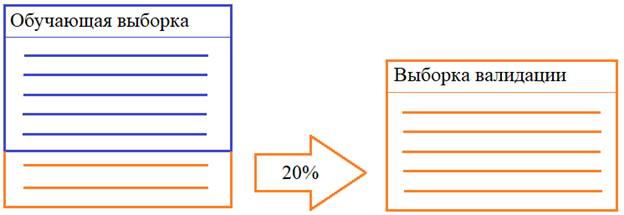

Плюсы этого подхода: автоматическое и случайное разбиение выборки на обучающую и проверочную и нам не нужно сильно «заморачиваться» для их формирования.

Недостаток: отсутствие доступа к конкретным наблюдениям этих выборок, т.к. мы не знаем какие из них были отобраны для валидации.

Другой способ – это вручную создать выборку валидации. Например, из 60 000 изображений обучающего множества – 10 000 отберем для проверки качества обучения сети. Это можно реализовать так:

size_val = 10000                        # размер выборки валидации

x_val_split = x_train[:size_val]        # выделяем первые наблюдения из обучающей выборки

y_val_split = y_train_cat[:size_val]    # в выборку валидации

x_train_split = x_train[size_val:]      # выделяем последующие наблюдения для обучающей выборки

y_train_split = y_train_cat[size_val:]

И, затем, запустить процесс обучения с этими множествами:

model.fit(x_train_split, y_train_split, batch_size=32, epochs=5,
          validation_data=(x_val_split, y_val_split))

Здесь мы уже четко знаем, что именно попадает в выборку валидации, но каждую эпоху будем использовать одни и те же наблюдения в этих выборках – они не будут перемешиваться между собой, как в предыдущем случае. И получаем больше шансов адаптации весовых коэффициентов сети именно под эти данные.

Наконец, третий вариант:

sklearn.model_selection.train_test_split

x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train, y_train_cat, test_size=0.2)

Плюс этой функции в том, что она автоматически случайным образом выделит 20% наблюдений и поместит их в выборку валидации, а остальные – в обучающую. И, далее, можно вызвать процесс обучения, указав эти множества:

model.fit(x_train_split, y_train_split, batch_size=32, epochs=5,
          validation_data=(x_val_split, y_val_split))


### Dropout

Итак, рассмотрим подробнее способы борьбы с переобучением НС. Это довольно частый эффект, который возникает из-за слишком точной подгонки разделительной гиперплоскости под обучающие данные.

Упрощенно, эффект переобучения можно представить следующим образом. Предположим, что мы читаем текст. Мозг среднестатистического человека устроен так, что мы хорошо воспринимаем слова, даже если буквы в них написаны не по порядку (кроме первой и последней):

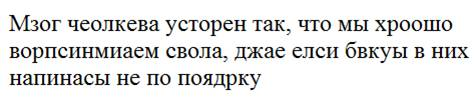

Если НС из-за большого числа нейронов подстроится под каждую букву слова, то этот текст для нее будет совершенно нечитаемым. Но сеть с небольшим числом нейронов, которая воспринимает слово в целом, сохранит способность к обобщению и правильному распознаванию.

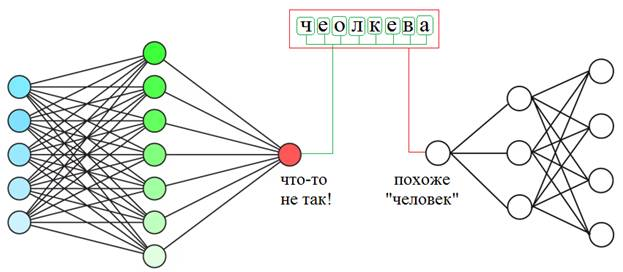

Но как в процессе обучения можно понять: происходит переобучение или нет? Один из критериев – это увеличение расхождения в точности выходных значений между данными обучающей выборки и проверочной:

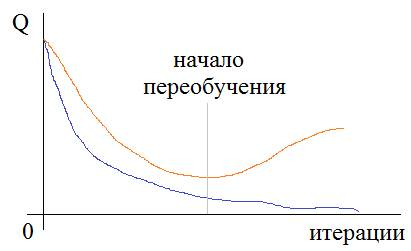

Рекомендация №1: если наблюдается расхождение в точности выходных значений между обучающей и проверочной выборками, то процесс обучения следует остановить и уменьшить число нейронов.

Но это не всегда дает желаемые результаты. Не редко с уменьшением числа нейронов уменьшается и точность выходных значений, то есть, показатель качества работы нейросети ухудшается. Очевидно, в таких случаях с переобучением нужно бороться с сохранением числа нейронов. В этом случае используется алгоритм

                                Dropout

На русский язык его переводят как «метод прореживания» или «метод исключения».

Цель этого метода – снизить специализацию каждого отдельного нейрона и сделать из них «специалистов более широкого профиля».  Именно в этом корень проблемы переобучения. Но как уменьшить специализацию, сохраняя прежнее число нейронов?
Теперь, осталось понять, как это сделать с  нейронами нейронной сети? Как в процессе обучения им «сказать», чтобы они брали на себя функции других нейронов? На каждой итерации изменения весовых коэффициентов часть нейронов нужно исключать с заданной вероятностью p:

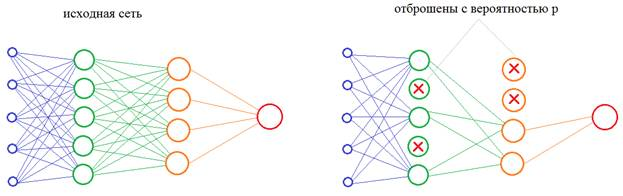

Нейроны в алгоритме dropout, то выключаются, то включаются. В какой же момент происходит их переключение? На каждой итерации изменения весов. Например, если веса меняются после каждого mini-batch, значит, переключение происходит после него. Если же веса меняются при каждом новом наблюдении, значит и переключение происходит с той же частотой. И так далее, то есть, переключение происходит после каждой корректировки весовых коэффициентов.

После того, как сеть обучена, включаются все нейроны и эффект переобучения (излишней специализации) должен заметно снизиться.

Однако, когда в процессе обучения с частью выключенных нейронов, мы пропускаем входной сигнал, то число входных связей на каждом нейроне уменьшается пропорционально вероятности p:

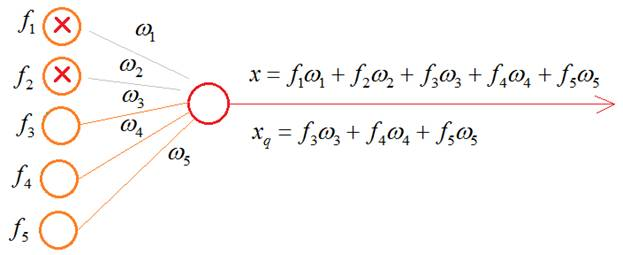

В режиме эксплуатации значение на входе нейрона будет x, а в момент обучения значение:

image.png

Это приводит к искаженным входным значениям, а значит, и к неверным результатам на выходе всей НС. Как поправить ситуацию, чтобы, в среднем, эти суммы были равными? Для этого нужно вычислить среднее число выключенных нейронов в текущем слое. Пусть их будет n штук. Найдем математическое ожидание, которое в дискретном случае определяется выражением:

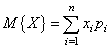

Роль случайной величины X играет число исключенных нейронов в текущем слое; image.png - вероятность выключения; image.png - число нейронов, к которым применяется эта вероятность. Получаем среднее значение:

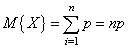

А среднее число оставшихся нейронов, будет равно:

image.png

где q – вероятность того, что нейрон останется (не будет исключен). Отсюда получаем, что средний суммарный сигнал на входах нейронов следующего слоя, в среднем, будет меньше на величину:

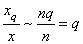

И из этого выражения хорошо видно, что для сохранения масштаба суммы, ее нужно разделить на величину q:

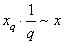

Во многих фреймворках алгоритм Dropout реализован именно так: суммарный сигнал на входах нейронов масштабируется, эмулируя поведение полной сети со всеми нейронами. Благодаря этому, в среднем, выходной сигнал сети соответствует истинным значениям.

Рекомендация №2: если наблюдается переобучение и сокращение числа нейронов недопустимо (по тем или иным причинам), то следует попробовать метод Dropout.

Но, как выбирать значение вероятности p? Авторы этого подхода рекомендуют для нейронов скрытого слоя начинать со значения p=0,5 (0,4 ; 0,3).

Также следует иметь в виду, что это не абсолютное средство: оно может как помочь, так и не помочь. Если эффекта нет, то от него лучше отказаться и искать другие пути выхода из сложившейся ситуации. И добавлять его в НС только в случае возникновения проблем с переобучением.

Реализация Dropout в Keras


Epoch 1/50
157/157 [==============================] - 3s 6ms/step - loss: 1.1664 - accuracy: 0.6240 - val_loss: 0.5032 - val_accuracy: 0.8716
Epoch 2/50
157/157 [==============================] - 1s 5ms/step - loss: 0.6338 - accuracy: 0.7990 - val_loss: 0.3714 - val_accuracy: 0.9026
Epoch 3/50
157/157 [==============================] - 1s 5ms/step - loss: 0.4929 - accuracy: 0.8544 - val_loss: 0.3240 - val_accuracy: 0.9100
Epoch 4/50
157/157 [==============================] - 1s 5ms/step - loss: 0.4332 - accuracy: 0.8664 - val_loss: 0.3158 - val_accuracy: 0.9084
Epoch 5/50
157/157 [==============================] - 1s 7ms/step - loss: 0.3788 - accuracy: 0.8888 - val_loss: 0.2940 - val_accuracy: 0.9082
Epoch 6/50
157/157 [==============================] - 1s 5ms/step - loss: 0.3613 - accuracy: 0.8910 - val_loss: 0.2721 - val_accuracy: 0.9166
Epoch 7/50
157/157 [==============================] - 1s 7ms/step - loss: 0.3260 - accuracy: 0.9026 - val_loss: 0.2549 - val_accuracy: 0.9238
Epoch 

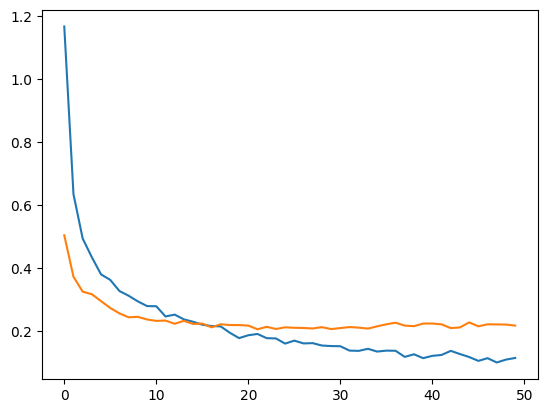

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist         # библиотека базы выборок Mnist
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# стандартизация входных данных
x_train = x_train / 255
x_test = x_test / 255

y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

limit = 5000
x_train_data = x_train[:limit]
y_train_data = y_train_cat[:limit]

x_valid = x_train[limit:limit*2]
y_valid = y_train_cat[limit:limit*2]

model = keras.Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(300, activation='relu'),
    Dropout(0.8),
    Dense(10, activation='softmax') ])

# print(model.summary())      # вывод структуры НС в консоль

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])


his = model.fit(x_train_data, y_train_data, epochs=50, batch_size=32, validation_data=(x_valid, y_valid))


plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.show()

###BatchNormalization

Внутренний ковариационный сдвиг:

Давайте предположим, что мы обучаем НС распознавать машины (неважно какие, главное чтобы сеть на выходе выдавала признак: машина или не машина). Но, при обучении используются автомобили только черного цвета. После этого, сеть переходит в режим эксплуатации и ей предъявляются машины уже разных цветов:

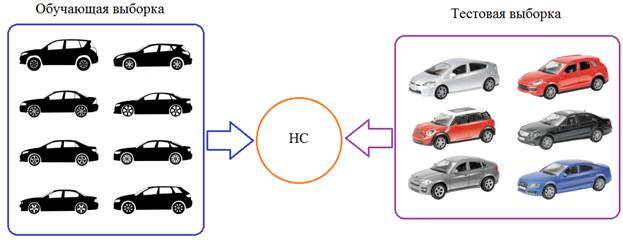

Это не лучшим образом скажется на качестве ее работы. Так вот, на языке математики этот эффект можно выразить так. Начальное распределение цветов (пусть это будут градации серого) обучающей выборки можно описать с помощью вот такой плотности распределения вероятностей (зеленый график):

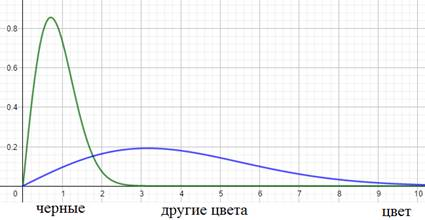

А распределение всего множества цветов машин, встречающихся в тестовой выборке в виде синего графика. Эти графики имеют различные МО и дисперсии. Эта разница статистических характеристик и приводит к ковариационному сдвигу. Если такой сдвиг имеет место быть, то это негативно сказывается на работе НС.

Но это пример внешнего ковариационного сдвига. Его легко исправить, поместив в обучающую выборку нужное количество машин с разными цветами. Кроме этого, существует внутренний ковариационный сдвиг – это когда статистическая картина меняется внутри сети от слоя к слою:

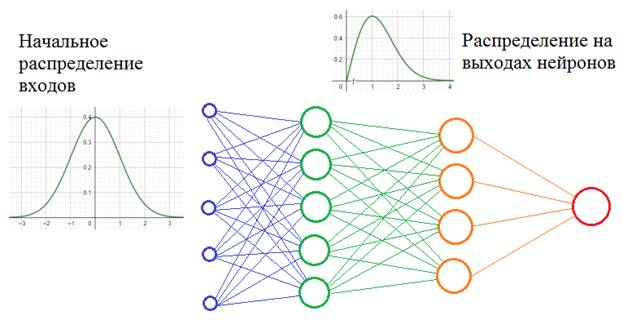

Само по себе такое изменение статистик не несет каких-либо проблем. Проблемы проявляются в процессе обучения, когда при изменении весов связей предыдущего слоя статистическое распределение выходных значений нейронов текущего слоя становится заметно другим. И этот измененный сигнал идет на вход следующего слоя. Это похоже на то, словно на вход скрытого слоя поступают то машины черного цвета, то машины красного цвета или какого другого. То есть, весовые коэффициенты в пределах мини-батча только адаптировались к черным автомобилям, как в следующем мини-батче им приходится адаптироваться к другому распределению – красным машинам и так постоянно. В ряде случаев это может существенно снижать скорость обучения и, кроме того, для адаптации в таких условиях приходится устанавливать малое значение шага сходимости, чтобы весовые коэффициенты имели возможность подстраиваться под разные статистические распределения.

Это описание проблемы, которую выявили сотрудники Гугла, изучая особенности обучения многослойных НС. Решение кажется здесь очевидным: если проблема в изменении статистических характеристик распределения на выходах нейронов, то необходимо их стандартизировать, нормализовывать – приводить к единому виду. Именно это и делается при помощи предложенного алгоритма

                            Batch Normalization

Но, какие характеристики и как следует нормировать. Из теории вероятностей следует, что самые значимые из них – первые две: МО и дисперсия. В алгоритме batch normalization их приводят к значениям 0 и 1, то есть, формируют распределение с нулевым МО и единичной дисперсией. Для каких величин и в какой момент производится эта нормировка? Разработчики этого метода рекомендовали располагать нормировку для величин  перед функцией активации:

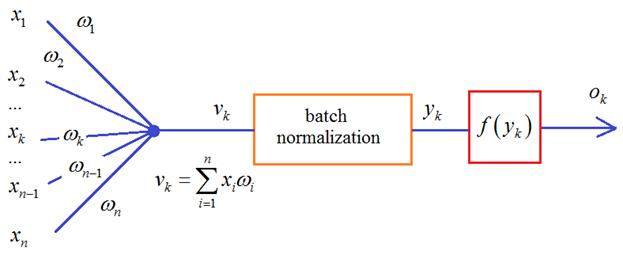

Но сейчас уже имеются результаты исследований, которые показывают, что этот блок может давать хорошие результаты и после функции активации.

Что же из себя представляет batch normalization и где тут статистики? Вспомним, что НС обучается пакетами наблюдений – батчами. И для каждого наблюдения из batch на входе каждого нейрона получается свое значение суммы:

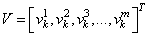

Здесь m – это размер пакета, число наблюдений в батче. Так вот статистики вычисляются для величин V в пределах одного batch:

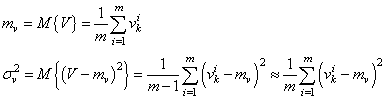

И, далее, чтобы вектор V имел нулевое среднее и единичную дисперсию, каждое значение преобразовывают по формуле:

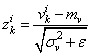

здесь image.png - небольшое положительное число, исключающее деление на ноль, если дисперсия будет близка к нулевым значениям. В итоге, вектор

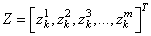

будет иметь нулевое МО и почти единичную дисперсию. Но этого недостаточно. Если оставить как есть, то будут теряться естественные статистические характеристики наблюдений между батчами: небольшие изменения в средних значениях и дисперсиях, т.е. будет уменьшена репрезентативность выборки:

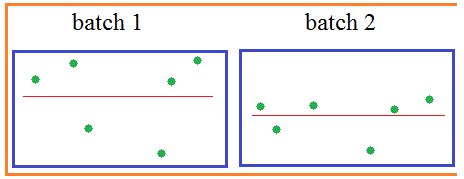

Кроме того, сигмоидальная функция активации вблизи нуля имеет практически линейную зависимость, а значит, простая нормировка значений x лишит НС ее нелинейного характера, что приведет к ухудшению ее работы:

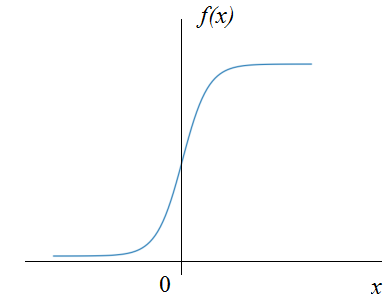

Поэтому нормированные величины  дополнительно масштабируются и смещаются в соответствии с формулой:

image.png

Параметры image.png с начальными значениями 1 и 0 также подбираются в процессе обучения НС с помощью того же алгоритма градиентного спуска. То есть, у сети появляются дополнительные настраиваемые переменные, помимо весовых коэффициентов.

Далее, величина  подается на вход функции активации и формируется выходное значение нейрона. Именно в этом заключается принцип работы алгоритма batch normalization, который дает следующие возможные эффекты:

- ускорение сходимости к модели обучающей выборки;

- бОльшая независимость обучения каждого слоя нейронов;

- возможность увеличения шага обучения;

- в некоторой степени предотвращает эффект переобучения;

- меньшая чувствительность к начальной инициализации весовых коэффициентов.

Но это лишь возможные эффекты – они могут и не проявиться или даже, наоборот, применение этого алгоритма ухудшит обучаемость НС. Рекомендация здесь такая:

Изначально строить нейронные сети без batch normalization (или dropout) и если наблюдается медленное обучение или эффект переобучения, то можно попробовать добавить batch normalization или dropout, но не оба вместе.

Реализация batch normalization в Keras

Посмотрим как можно реализовать данный алгоритм в пакете Keras. Для этого существует класс специального слоя, который так и называется:

keras.layers.BatchNormalization

Он применяется к выходам предыдущего слоя, после которого указан в модели НС

Epoch 1/50
157/157 [==============================] - 3s 7ms/step - loss: 0.4621 - accuracy: 0.8602 - val_loss: 0.5011 - val_accuracy: 0.9004
Epoch 2/50
157/157 [==============================] - 1s 6ms/step - loss: 0.1753 - accuracy: 0.9488 - val_loss: 0.3000 - val_accuracy: 0.9128
Epoch 3/50
157/157 [==============================] - 1s 6ms/step - loss: 0.1076 - accuracy: 0.9736 - val_loss: 0.2416 - val_accuracy: 0.9280
Epoch 4/50
157/157 [==============================] - 1s 8ms/step - loss: 0.0761 - accuracy: 0.9806 - val_loss: 0.2238 - val_accuracy: 0.9310
Epoch 5/50
157/157 [==============================] - 1s 6ms/step - loss: 0.0510 - accuracy: 0.9878 - val_loss: 0.2005 - val_accuracy: 0.9384
Epoch 6/50
157/157 [==============================] - 1s 6ms/step - loss: 0.0394 - accuracy: 0.9912 - val_loss: 0.2200 - val_accuracy: 0.9324
Epoch 7/50
157/157 [==============================] - 1s 6ms/step - loss: 0.0241 - accuracy: 0.9970 - val_loss: 0.1997 - val_accuracy: 0.9360
Epoch 

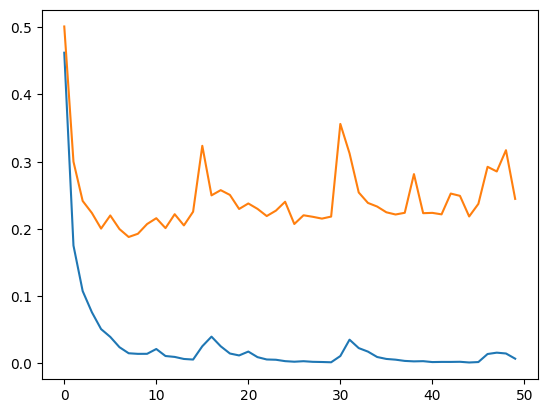

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist         # библиотека базы выборок Mnist
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# стандартизация входных данных
x_train = x_train / 255
x_test = x_test / 255

y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

limit = 5000
x_train_data = x_train[:limit]
y_train_data = y_train_cat[:limit]

x_valid = x_train[limit:limit*2]
y_valid = y_train_cat[limit:limit*2]

model = keras.Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(300, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='softmax') ])

# print(model.summary())      # вывод структуры НС в консоль

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])


his = model.fit(x_train_data, y_train_data, epochs=50, batch_size=32, validation_data=(x_valid, y_valid))


plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.show()

# Пример создания сверточных и пуллинг слоев

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D

(8, 9)


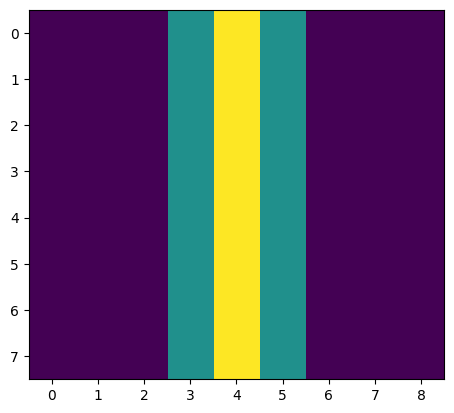

In [2]:
# определение входных данных
data = [[0, 0, 0, 1, 2, 1, 0, 0, 0],
            [0, 0, 0, 1, 2, 1, 0, 0, 0],
            [0, 0, 0, 1, 2, 1, 0, 0, 0],
            [0, 0, 0, 1, 2, 1, 0, 0, 0],
            [0, 0, 0, 1, 2, 1, 0, 0, 0],
            [0, 0, 0, 1, 2, 1, 0, 0, 0],
            [0, 0, 0, 1, 2, 1, 0, 0, 0],
            [0, 0, 0, 1, 2, 1, 0, 0, 0]]

data = np.asarray(data).astype(np.float64)
print(data.shape)
plt.imshow(data)

In [3]:
data = data.reshape(1, 8, 9, 1)

In [4]:
data

array([[[[0.],
         [0.],
         [0.],
         [1.],
         [2.],
         [1.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [1.],
         [2.],
         [1.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [1.],
         [2.],
         [1.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [1.],
         [2.],
         [1.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [1.],
         [2.],
         [1.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [1.],
         [2.],
         [1.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [1.],
         [2.],
         [1.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0

In [5]:
max_pooling = MaxPooling2D(pool_size=(1, 3), strides=(1, 2))
avg_pooling = AveragePooling2D(pool_size=(1, 3), strides=(1, 2))

(1, 8, 4, 1)
[[0. 2. 2. 0.]
 [0. 2. 2. 0.]
 [0. 2. 2. 0.]
 [0. 2. 2. 0.]
 [0. 2. 2. 0.]
 [0. 2. 2. 0.]
 [0. 2. 2. 0.]
 [0. 2. 2. 0.]]


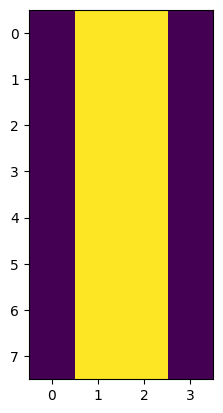

In [6]:
max_pooling_data = max_pooling(data)
print(max_pooling_data.shape)
_, h, w, _ = max_pooling_data.shape
plt.imshow(max_pooling_data.numpy().reshape(h, w))
print(max_pooling_data.numpy().reshape(h, w))

(1, 8, 4, 1)
[[0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]]


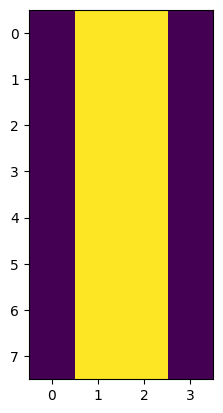

In [7]:
avg_pooling_data = avg_pooling(data)
print(avg_pooling_data.shape)
_, h, w, _ = avg_pooling_data.shape
plt.imshow(avg_pooling_data.numpy().reshape(h, w))
print(avg_pooling_data.numpy().reshape(h, w))

In [8]:
# создание модели
model = Sequential()
model.add(Conv2D(1, (3,3), activation='relu', input_shape=(8, 9, 1)))

# вывод описания созданной модели
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 7, 1)           10        
                                                                 
Total params: 10 (40.00 Byte)
Trainable params: 10 (40.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
model.layers[0].get_weights()[1]

array([0.], dtype=float32)

In [16]:
# определение дектора вертикальной линии
detector = [[[[0]],[[1]],[[0]]],
            [[[0]],[[1]],[[0]]],
            [[[0]],[[1]],[[0]]]]

weights = [np.asarray(detector), np.asarray([0.0])]
# сохранение весов в модель
model.set_weights(weights)

In [17]:
yhat = model.predict(data)
yhat.shape

1/1 [==============================] - 1s 1s/step


(1, 6, 7, 1)

In [18]:
yhat.reshape(6, 7)

array([[0., 0., 3., 6., 3., 0., 0.],
       [0., 0., 3., 6., 3., 0., 0.],
       [0., 0., 3., 6., 3., 0., 0.],
       [0., 0., 3., 6., 3., 0., 0.],
       [0., 0., 3., 6., 3., 0., 0.],
       [0., 0., 3., 6., 3., 0., 0.]], dtype=float32)

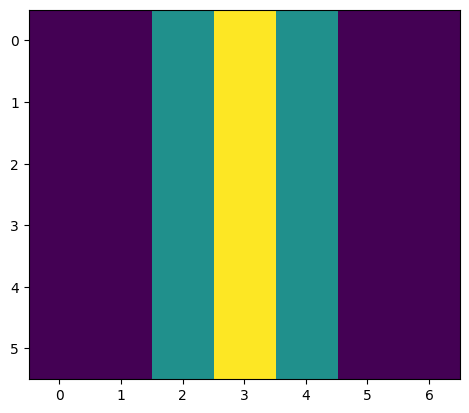

In [19]:
plt.imshow(yhat.reshape(6, 7))

# Нейронная сеть Lenet5

In [20]:
from keras.datasets import mnist
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow import keras

In [21]:
# загрузка тренировочных и тестовых данных
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# конвертация чисел из uint8 в float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# нормализация данных [0, 1]
x_train /= 255
x_test /= 255

# трансформация лейблов в one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# изменение размерности массива в 4D массив
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

11490434/11490434 [==============================] - 0s 0us/step


In [22]:
x_train[0].shape

(28, 28, 1)

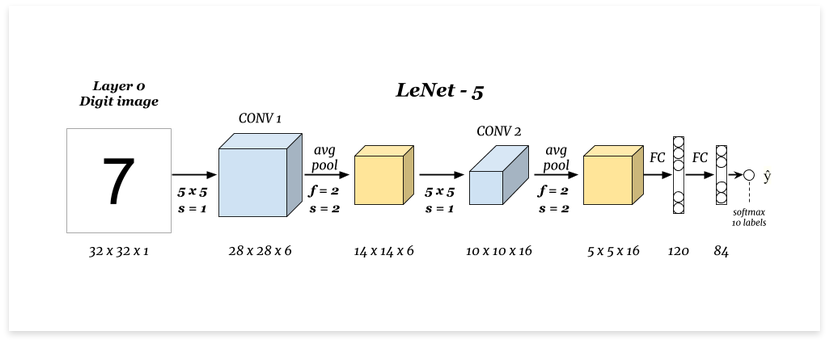

In [23]:
# инициализация пустой модели
model = Sequential()

# первый сверточный слой
model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1)))

# второй пуллинговый слой
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

# третий сверточный слой
model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh'))

# четвертый пуллинговый слой
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

# сглаживание CNN выхода чтобы можно было его присоединить к полносвязногому слою
model.add(layers.Flatten())

# пятый полносвязный слой
model.add(layers.Dense(120, activation='tanh'))

# шестой полносвязный слой
model.add(layers.Dense(84, activation='tanh'))

# выходной слой с функцией активации softmax
model.add(layers.Dense(10, activation='softmax'))

In [65]:
# инициализация пустой модели
model = Sequential()

convolutional = Sequential([
                            layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1)),
                            layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
                            layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh'),
                            layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))
])

linear = Sequential([
                            layers.Flatten(),
                            layers.Dense(120, activation='tanh'),
                            layers.Dense(84, activation='tanh'),
                            layers.Dense(10, activation='softmax')
])


model.add(convolutional)
model.add(linear)

In [66]:
model.layers[0].layers[0].get_weights()[0]

array([[[[ 0.13416593,  0.10643585,  0.1656517 , -0.18181634,
           0.13076837, -0.02743323]],

        [[ 0.13691221,  0.17346285, -0.02414405, -0.00968292,
           0.1602277 , -0.13213167]],

        [[ 0.00135936, -0.02811335, -0.15559754,  0.04024747,
          -0.13478558, -0.1266962 ]],

        [[ 0.1123706 ,  0.06572454, -0.07831791,  0.03433762,
           0.1084889 , -0.14344637]],

        [[ 0.03659162, -0.12315989,  0.13140137,  0.16376628,
          -0.11045694, -0.12334318]]],


       [[[ 0.1512687 ,  0.10711394, -0.11310079, -0.0663813 ,
           0.10368831,  0.16855218]],

        [[ 0.1568151 ,  0.0750749 ,  0.14845102,  0.00288838,
          -0.08565714, -0.04439707]],

        [[ 0.09751134, -0.11700109,  0.13882996, -0.06508613,
           0.05912696,  0.17865355]],

        [[ 0.15508048, -0.11323398,  0.14222996,  0.02388275,
           0.10943209, -0.09764028]],

        [[-0.10917974,  0.14502202,  0.0466104 ,  0.17532773,
          -0.15858564, -0.1

In [31]:
model.layers[0].layers[0].get_weights()[0].shape

(5, 5, 1, 6)

In [ ]:
model.layers[0].layers[1].get_weights()

[]

In [32]:
model.layers[0].layers[2].get_weights()[0].shape

(5, 5, 6, 16)

In [40]:
!pip install keras_metrics

In [41]:
import keras_metrics

In [44]:
# компиляция модели
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=[keras.metrics.Precision()])

hist = model.fit(x=x_train,y=y_train, epochs=6, batch_size=128, verbose=1)

test_score = model.evaluate(x_test, y_test)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))


Epoch 1/6
469/469 [==============================] - 4s 5ms/step - loss: 0.2476 - precision: 0.9490
Epoch 2/6
469/469 [==============================] - 3s 6ms/step - loss: 0.2285 - precision: 0.9526
Epoch 3/6
469/469 [==============================] - 2s 4ms/step - loss: 0.2120 - precision: 0.9554
Epoch 4/6
469/469 [==============================] - 2s 4ms/step - loss: 0.1971 - precision: 0.9587
Epoch 5/6
469/469 [==============================] - 2s 4ms/step - loss: 0.1843 - precision: 0.9610
Epoch 6/6
313/313 [==============================] - 1s 3ms/step - loss: 0.1568 - precision: 0.9658
Test loss 0.1568, accuracy 96.58%


# Более сложная нейронная сеть

In [45]:
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import os

In [46]:
# установка параметров нейросети
batch_size = 128
num_classes = 10
epochs = 5
data_augmentation = True
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [47]:
# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

170498071/170498071 [==============================] - 5s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [48]:
def plot_images(images, labels):
  fig, axes = plt.subplots(1, len(images), figsize = (10, 5))
  for im, l, ax in zip(images, labels, axes):
    ax.imshow(im.reshape(32, 32, 3))
    ax.set_title(l.argmax())

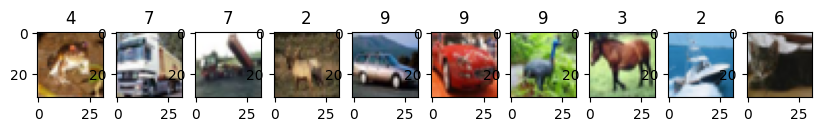

In [49]:
plot_images(x_train[:10], y_train[10:20])

In [57]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

In [58]:
dg = datagen.flow(x_train[:5], batch_size=1)

In [52]:
dg[0]

array([[[[0.08087552, 0.08648934, 0.08044586],
         [0.08087552, 0.08648934, 0.08044586],
         [0.06153869, 0.0577137 , 0.04846703],
         ...,
         [0.5300895 , 0.38349426, 0.2411041 ],
         [0.49833456, 0.35836878, 0.22106822],
         [0.4708497 , 0.33324957, 0.20182331]],

        [[0.11415515, 0.09613214, 0.07429498],
         [0.11415515, 0.09613214, 0.07429498],
         [0.11133624, 0.07924041, 0.04796444],
         ...,
         [0.5296601 , 0.3768493 , 0.22403851],
         [0.49670273, 0.3505861 , 0.20527025],
         [0.47515953, 0.33385363, 0.19447683]],

        [[0.16365811, 0.11214066, 0.07472464],
         [0.16365811, 0.11214066, 0.07472464],
         [0.17465582, 0.10835015, 0.05686131],
         ...,
         [0.4805766 , 0.3246191 , 0.1706761 ],
         [0.43880937, 0.2963256 , 0.15581359],
         [0.40100342, 0.27121753, 0.14502573]],

        ...,

        [[0.6998389 , 0.55517054, 0.4167604 ],
         [0.6998389 , 0.55517054, 0.4167604 ]

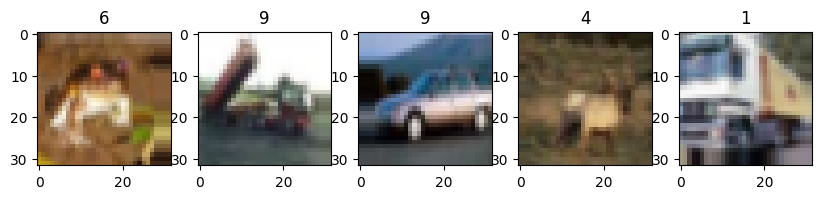

In [59]:
plot_images(dg, y_train[:5])

In [60]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


In [61]:
# инициализация RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001) # , decay=1e-6

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [62]:
# запуск data augmentation через fit_generator
model.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test))

Epoch 1/5


<ipython-input-62-76e73249f6a1>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(x_train, y_train,


391/391 [==============================] - 35s 81ms/step - loss: 2.0507 - accuracy: 0.2398 - val_loss: 1.8197 - val_accuracy: 0.3722
Epoch 2/5
391/391 [==============================] - 30s 76ms/step - loss: 1.7955 - accuracy: 0.3453 - val_loss: 1.6192 - val_accuracy: 0.4266
Epoch 3/5
391/391 [==============================] - 30s 76ms/step - loss: 1.6839 - accuracy: 0.3830 - val_loss: 1.6009 - val_accuracy: 0.4201
Epoch 4/5
391/391 [==============================] - 31s 80ms/step - loss: 1.5977 - accuracy: 0.4177 - val_loss: 1.4583 - val_accuracy: 0.4779
Epoch 5/5
391/391 [==============================] - 28s 73ms/step - loss: 1.5381 - accuracy: 0.4408 - val_loss: 1.4049 - val_accuracy: 0.4935


In [ ]:
# сохранение модели и весов
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('сохранить обученную модель как %s ' % model_path)


сохранить обученную модель как /content/saved_models/keras_cifar10_trained_model.h5 


In [63]:

# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 2s 6ms/step - loss: 1.4049 - accuracy: 0.4935
Test loss: 1.404920220375061
Test accuracy: 0.4934999942779541
